# Teeth Detection 

To perform the task of detect if a person is showing their theets given the dataset provided **muct-a-jpg-v1.tar.gz** as training set I'm gonna divide the task in several smaller ones, as follows:
___

## 0. File uncompressing

In [1]:
!mkdir ./train/
!mkdir ./test/
!tar -xf ./muct-a-jpg-v1.tar.gz -C ./train
!tar -xf ./muct-b-jpg-v1.tar.gz -C ./test

## 1. Image anotation

The images in the dataset provided haven't any tags to perform the training so I take into account two different ways to perform the training, as knows **Supervised Learning** or **Unsupervised Learning**, the first approach need tags, given the image tell the learning algorithm if there is a person showing their teeths or not otherwise.

The second approch let the algorithm to understand by itself the difference between showing or not their teeths, that is a lot harderd task because many of the state of the art algorithms in image recognition doesn't fall into this category. Therefore I choose Supervised Learning and forge by hand the tags associated with each image taking that in mind I subdivide this task of **Image Anotation**.

### 1.1 Tags file forgery

I'm gonna use an auxiliar file where each image file will have their related tag, thus I need to create a list with the files and the tags for each one.



In [2]:
import os
import pandas as pd

def get_files_list(path):
    '''
       Return the file list given a path using the linux command called 'tree'
       Args: 
           path: String
               the path to get the files list
    '''
    init_list=!tree -a -f -R -i $path 
    files=[]
    for f in init_list:
        #if isn't a directory or a jupyter notebook append to the file list
        if not(os.path.isdir(f)) and ('ipynb' not in f):
            files.append(f)
    files = files[0:-2]
    files = [x.split('/')[-1] for x in files]#get only the filename
    files = [(x, 0) for x in files] #append zero tag to each file
    return pd.DataFrame(data=files, columns=["file", "is_showing_theets"]) #convert the list to pandas dataframe 
    

In [3]:
files=get_files_list('./train/jpg/') 

files.to_csv("train_classes.csv", index=False) #save as csv
files.head()

,file,is_showing_theets
0,i000qa-fn.jpg,0
1,i000ra-fn.jpg,0
2,i000sa-fn.jpg,0
3,i001qa-mn.jpg,0
4,i001ra-mn.jpg,0


### 1.2 Manually change the tags for each Image

Once I have the initial file, now I need to proceed to change the tag **0** to **1** if in that file the person are actually showing their teeths, this task need to be done by hand. The file with the handcrafted tags is in the *bak* directory, so it's necesary to replace the file.



In [1]:
!cp bak/train_classes.csv ./

### 1.3 Load CVS file with tags

When the categorization are done reload the csv with the tags to be used in the training phase.

In [4]:
files = pd.read_csv("train_classes.csv")
files.head()

,file,is_showing_theets
0,i000qa-fn.jpg,1
1,i000ra-fn.jpg,0
2,i000sa-fn.jpg,1
3,i001qa-mn.jpg,0
4,i001ra-mn.jpg,0


### 1.4 Verify the Dataset Distribution

This task belongs to a binary classification problem, so I need to be sure that the dataset is balanced, that means  approximately 50% of the images are people with the tag **0** and the other 50% approximately have the tag **1**.

Ensure this condition is critical to the correct training of the algorithm because an unbalanced dataset tipically fails to generalize the task, therefore failing our goal.

In [5]:
shw = files[files.is_showing_theets == 1].count().values[0]
not_shw = files[files.is_showing_theets == 0].count().values[0]
total_examples = files.count().values[0]

print ("The training set have {} examples, {} of them have people showing their teeths, while {} not.".format(total_examples, shw, not_shw))

The training set have 751 examples, 345 of them have people showing their teeths, while 406 not.


As we can see is fairly balanced so we can continue.
___

## 2. Train/Validation Dataset Splitting

Is a good practice to divide our original dataset into train and validation data, this practice is intended to use the validation data to evaluate if the model is really learning in other words is used as a training metric.

In [6]:
import os
import shutil
def split_dataset(files_list, input_path = "./train/jpg/", output_path = "./validation/jpg/", validation_ratio=0.2):
    '''
        Randomly split into train/value datasets, puts in folder 0 not showing teeths 1 otherwise
        Args:
            files_list : (Pandas DataFrame)
            The loaded CVS with tags by image
        KWargs:
            * input_path : (String)
                The path to the folder were the training files lives
            * output_path : (String)
                The path of the validation folder
            * validation ratio : (float) [0:1]
                The ratio of validation examples, default 0.2 (20%)
    '''
    if not os.path.exists(output_path):
        os.makedirs(output_path+'0/')
        os.makedirs(output_path+'1/')
        os.makedirs(input_path+'0/')
        os.makedirs(input_path+'1/')
    else:
        return
    total_examples = files_list.count().values[0]
    n_validation = int(total_examples*validation_ratio)
    not_shw = files_list[files_list.is_showing_theets==0].sample(int(n_validation/2)).reset_index(drop = True)
    shw = files_list[files_list.is_showing_theets==1].sample(int(n_validation/2)).reset_index(drop = True)
    
    #move validation files into folders
    for i in not_shw["file"].values:
        shutil.move(input_path+i, output_path+'0/')
    for i in shw["file"].values:
        shutil.move(input_path+i, output_path+'1/')
        
    validation = pd.concat([not_shw, shw], ignore_index=True)
    train  = files_list[~files_list.file.isin(validation.file)]
    
    #move training files into folders
    for i in train[train.is_showing_theets == 0]["file"].values:
        shutil.move(input_path+i, input_path+'0/')
    for i in train[train.is_showing_theets == 1]["file"].values:
        shutil.move(input_path+i, input_path+'1/')
        
    return (train, validation)
    

In [7]:
(train, validation) = split_dataset(files)

In [8]:
train.sample(3)

,file,is_showing_theets
208,i069ra-fg.jpg,0
569,i298va-fn.jpg,0
675,i439wa-mn.jpg,0


In [9]:
validation.sample(3)

,file,is_showing_theets
131,i272va-fg.jpg,1
59,i252ua-fn.jpg,0
93,i268ua-mn.jpg,1


Now our dataset were splitted into train/val, and each class lives in their own folder therefore the files are no longer mixed, the folder structure now is:

In [10]:
! tree ./train -L 2

./train
`-- jpg
    |-- 0
    `-- 1

3 directories, 0 files


In [11]:
! tree ./validation -L 2

./validation
`-- jpg
    |-- 0
    `-- 1

3 directories, 0 files


Note that **0** means not showing teeths, meanwhile **1** otherwise.
___

## 3. Dataset Augmentation

The selected subset of algorithms based on **Neural Networks** were **Convolutional Neural Networs** this kind of networks are the state of the art in the tasks that involves image processing, but this kind of networks have a drawback, to correctly perfom the task needs a lot of labeled data, 750 is a nice number but in my own experience cannot be enough data to ensure a good behaviour of our neural net. 

Therefore in this second step I'm gonna perform a task of artifitial data augmentation that consist in take every previously labeled image and perform transformations such as rotation, traslation, color channel shifting etc. then take that new artifitial examples and perform the training phase.

With the purpouse to ilustrate the general process, I prepared the nex snippet of code.

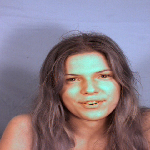

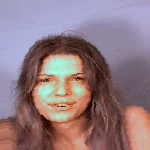

In [13]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from IPython.display import display
import numpy as np

sample = train[train.is_showing_theets==1].sample(1).values[0][0] #get a random sample
img = load_img('./train/jpg/1/'+sample, target_size=(150, 150)) #load and scale a sample img
img_np = img_to_array(img)  # to Numpy array(tensor)
img_np = np.expand_dims(img_np, axis=0)  # append a new dimension

datagen = ImageDataGenerator(
        rotation_range=50,
        horizontal_flip=True,
        channel_shift_range = 10.0,
        fill_mode='nearest')
transformed_img = array_to_img(datagen.flow(img_np, [0], batch_size=1).next()[0].squeeze())
display(img, transformed_img)

Now I'll create the gerators that actually will be used into our training model.

In [14]:
train_generator = datagen.flow_from_directory(
        './train/jpg/',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=10, #size of the batches of data
        class_mode='binary') #type of classification

Found 601 images belonging to 2 classes.


In [15]:
validation_generator = datagen.flow_from_directory(
        './validation/jpg/',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=10, #size of the batches of data
        class_mode='binary') #type of classification

Found 150 images belonging to 2 classes.


___
## 4. Training

### 4.1 Rationale


#### 4.1.1 Model Rationale

Outhere exist a lot of models that can solve our problem, nowadays the state of the art in image classification are **Convolutional Neural Networks** since the famous **Alex Krizhevsky** paper of 2012 make a major breakthrough, in that paper introduce the network known now as [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). Since then another famous nets have appeared like the Google's [Inception](https://arxiv.org/pdf/1512.00567.pdf), [VGG](https://arxiv.org/pdf/1409.1556.pdf), and [ResNet](https://arxiv.org/pdf/1512.03385.pdf) all of them based in the same principles but with some modiffications here and there.

A network that have a really good balance between accuracy and model size is **ResNet50** that network have the characteristic that instead of learn a function $f(x)$ that maps the images as input $x$, learns a function of the form $f(x)+x$ that means the input can jump to deep layers of the network allowing faster training, improving the accuracy of the model, and fight the problem of devanishing gradient that usually happen with very deep neural nets.

The image below shows a basic building block of the **ResNet** network.

![Image of Resnet50](https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/resnets_1.png)

* **Convolution Layer:** Perform the convolution operator between subsets of the input image.
* **Batch Norm:** Acts as regularizer of the network.
* **ReLU:** Non-linear operator, is the activation function.
* **Addition:** Just is a vectorial sum between vectors.

> ResNet50 is a Residual Network (ResNet) that has 50 layers deep.

#### 4.1.2 Classifier Rationale

On top of the ConvNet I'll use a softmax classifier, this is just a dense layer that maps the feature vector of the hidden layer to a probability distribution between the classes, it's relvant to remark as we're doing a binary classifier the softmax classifier it's just a sigmoid function $h_\theta$, the general schema is represented in the following image:

![Image of Resnet50](https://corpocrat.com/wp-content/uploads/2014/10/nn-600x426.png)
**Sigmoid Function**
$$h_\theta = \frac{1}{e^{-z}}$$
where $z$ is the vector of the hidden layer.

#### 4.1.3 Loss Function Rationale

Once the model and classifier are selected just need to adopt a loss function that measures the classification error, since this problem is a binary classification problem I'll choose the **Binary Cross Entropy** that is defined as:

$$-\frac{1}{N}\sum^N_{i=1}y_ilog(h_\theta(x_i))+(1-y_i)log(1-h_\theta(x_i))$$

where
* $N$ is the total number of training examples 
* $y_i$ is the real class of the example $i$-th
* $h_\theta(x_i)$ is the output of the classifier $h$ given the input image $x_i$

therefore if the actual label of the example $x_i$ is 1 (is showing their teeths) is translated as $y_i=1$ and the model predicts wrongly that label for instance predict 0 (is not showing their teeths) is translated as $h_\theta(x_i)=0$ so, the error will be calculated only with the term of the left of the plus sign.

The procedure is simmilar when $y_i=0$ but in that case the error will be calculated with the right term of the plus sign.

> In other words binary cross entropy just measure the error of each classification and perform an average of the errors

#### 4.1.3 Optimizer Rationale

Outhere exist a lot of strategies to perform optimization, that it's the strategy used to minimize the error/loss function; typically **Stochastic Gradient Descent** (SGD) is used but require a lot of tweaking with hyperparams, by experience **Adadelta** shows a good behavior without mess with hyperparams.

> In [this](http://sebastianruder.com/optimizing-gradient-descent/index.html) blog you can find more information.


![Image of Optimizers](http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif)

#### 4.1.4 Training Strategy Rationale (Transfer Learning) 

With the goal to train the network I'll use the methodology known as **Transfer Learning**, in this technique a model can reuse the knowledge derived of a similar task as a strong bias and a well behaved starting point that helps to train the model orders of magnitude faster, and often can improve the accuracy of the final model.

![Transfer Learning Image](https://image.slidesharecdn.com/transferdefectlearningnewcompleted-130526123501-phpapp01/95/transfer-defect-learning-20-638.jpg?cb=1369571792)

For that purpose the training will be divided in two subtasks:

* **Training with frozen weights:** Using the weights of a pretrained ResNet50, that have been trained with the dataset of [Imagenet (ILSVRC 2012)](http://image-net.org/challenges/LSVRC/2012/) with 150.000 images and 1.000 categories use as initial weights and perform a training phase only of the softmax classifier, letting the weights of the convnet statical. This steps allow us to use previous knowledge of a previous similar task and train a classifier with that knoledge.

* **Training with UNfrozen weights:** Once the classifier doesn't improve with the Imagenet weights, proceed to unfreeze the weighs, allowing all weights of the convnet to update, in a process called **fine-tunning** of the weights with the goal of speciallize the convnet for our task. This phase is intended to adjust the neural net specifically for our classification problem. 


### 4.2 Model Training Transfer Learning (I)
#### 4.2.1 Forge the model
The first phase is to create our model and load the weighs of ImageNet

In [16]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import backend as K
from keras.layers import Dense, Flatten, Input, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import numpy as np

def get_input_shape(img_rows=224, img_cols = 224):
    '''
        Helper function that organize the inputs taking into account if is runing into a tensorflow or theano backend
    '''
    if K.image_dim_ordering() == 'th':
        input_shape = (3, img_rows, img_cols)
    else:
        input_shape = (img_rows, img_cols, 3)
    return Input(shape=input_shape)  

#model construction
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=get_input_shape()) #use resnet as base model and imagenet weights
x = base_model.output
x = Flatten()(x) #flat the tensor to a 1-d vector
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid', name='sigmoid')(x)#append at the end of the network the classifier
model = Model(input=base_model.input, output=x) #the final model


#### 4.2.2 Create helper callbacks
Once the model is created, it's important to add some callbacks that will be executed after each trainin epoch

In [17]:
#save the model weights when the model improve the validation accuracy
checkpoint = ModelCheckpoint('weights_fixed_imagenet.h5',
                             monitor = 'val_acc', 
                             save_best_only = True, 
                             mode = 'max', 
                             save_weights_only = True,
                             verbose = 1)
#if the classifier doesn't improve stop this phase earlier
early_stop = EarlyStopping(monitor = 'val_acc', 
                           min_delta = 0.001, 
                           patience = 15, 
                           verbose = 1,
                           mode='max')
#log each trainning epoch
logger = CSVLogger('training_fixed_imagenet_weights.log')

#### 4.2.3 Freeze weights
Now freeze the ImageNet weights to avoid change in this phase, and compile the model

In [18]:
#Freeze the imagenet weights
for layer in model.layers[0:-3]:
    layer.trainable = False
#compile the model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adadelta',
              metrics = ['accuracy'])

Now we have our networ ready to train, below you can see the achitecture of the network, note that it's a very deep and complex network.

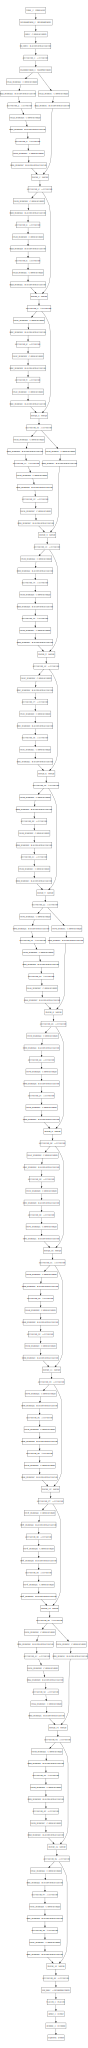

In [19]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### 4.2.4 Perform the trainig of the classifier only 

In [20]:
%%time
history = model.fit_generator(
        train_generator,
        samples_per_epoch = 3005, #number of samples to process before going to the next epoch (training_imgs*5)
        nb_epoch = 50, #total number of iterations on the data (epochs)
        validation_data = validation_generator,
        nb_val_samples = 600, #number of samples for validation (validation_imgs*4)
        verbose = 0,
        callbacks = [logger, checkpoint, early_stop])

Epoch 00000: val_acc improved from -inf to 0.54500, saving model to weights_fixed_imagenet.h5
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc did not improve
Epoch 00003: val_acc improved from 0.54500 to 0.62500, saving model to weights_fixed_imagenet.h5
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc improved from 0.62500 to 0.62500, saving model to weights_fixed_imagenet.h5
Epoch 00007: val_acc did not improve
Epoch 00008: val_acc improved from 0.62500 to 0.70333, saving model to weights_fixed_imagenet.h5
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc did not improve
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc did not improve
Epoch 00015: val_acc did not improve
Epoch 00016: val_acc did not improve
Epoch 00017: val_acc did not improve
Epoch 00018: val_acc did not improve
Epoch 00019: val_acc did not improve
Epoch 00020: val_acc di

### 4.3 Model Training Transfer Learning (II)
Once the classifier doesn't improve any further with the ImageNet weights, now proceed to **fine-tune** the network

#### 4.3.1 Load the weights of the phase I
Ensure that the model now have the weights of the best version of the network until now, that should be saved using the checkpoint callback

In [21]:
#load weights
model.load_weights('weights_fixed_imagenet.h5')

#### 4.3.2 Update the callbacks
This phase also need a log and checkpoints instances

In [22]:
#update callbacks
logger.filename ='fine_tunning.log'
checkpoint.filepath= 'weights_fine_tunning.h5'

#### 4.3.3 Unfreeze the weights
Now is necessary speciallize the network for the teeth detection task, by that proceed to unfreeze the weights

In [23]:
#unfreeze convnet layers
for layer in model.layers:
    layer.trainable = True

#### 4.3.4 Perform the fine-tunning of the network

In [24]:
%%time
#perform the fine tunning
history_fine_tunning = model.fit_generator(
                            train_generator,
                            samples_per_epoch=3005, #number of samples to process before going to the next epoch (training_imgs*5)
                            nb_epoch=100, # total number of iterations on the data
                            validation_data=validation_generator,
                            nb_val_samples=600,#number of samples to use from validation generator at the end of every epoch 
                            verbose = 0,
                            callbacks = [logger, checkpoint])

Epoch 00000: val_acc did not improve
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc did not improve
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc improved from 0.70333 to 0.71333, saving model to weights_fine_tunning.h5
Epoch 00007: val_acc improved from 0.71333 to 0.71667, saving model to weights_fine_tunning.h5
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc did not improve
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc did not improve
Epoch 00015: val_acc did not improve
Epoch 00016: val_acc did not improve
Epoch 00017: val_acc did not improve
Epoch 00018: val_acc did not improve
Epoch 00019: val_acc did not improve
Epoch 00020: val_acc did not improve
Epoch 00021: val_acc did not improve
Epoch 00022: val_acc did not improve
Epoch 00023: val_acc did not impr

___
## 5. Prediction

Once the trainig phase has ended, just need to classify the test images that our network never has seen before.

### 5.1 Load final weights
Ensure that the weights that use the model has the best the network could find.

In [25]:
#load final weights
model.load_weights('weights_fine_tunning.h5')

### 5.2 Predict and move files
Now we need to perform the prediction of each image of the test set, also given the classification output move each image into one of the folders **0** or **1**. For that task I've created the next function.

In [26]:

def classify_test_files(working_path = './test/jpg/', batch_size = 10 ):
    if not os.path.exists(working_path+'0/'):
        os.makedirs(working_path+'0/')
    if not os.path.exists(working_path+'1/'):
        os.makedirs(working_path+'1/')
    files=get_files_list('./test/jpg/')
    n_files = len(files.index)
    
    #load the test images and transforms them into array representation
    np_images=[]
    for index in files.index:
        np_images.append(img_to_array(load_img('./test/jpg/'+files.get_value(index, "file"), target_size=(224, 224))))

    #perform the prediction in batches
    for batch in range(np.ceil(n_files/batch_size).astype(np.int32)):
        prediction = model.predict_on_batch(np.array(np_images[batch*batch_size : min(batch*batch_size+batch_size, n_files)]))
        prediction = [1 if x>=0.5 else 0 for x in prediction] #map from probability to categories tags
        for index in range(len(prediction)):
            files.set_value(batch*batch_size+index, 'is_showing_theets', prediction[index])
            
    #move test files into folders
    for i in files.values:
        if i[1]==0:
            shutil.move(working_path+i[0], working_path+'0/')
        else:
            shutil.move(working_path+i[0], working_path+'1/')
    return files

In [27]:
classification_results = classify_test_files()
classification_results.head()

,file,is_showing_theets
0,i000qb-fn.jpg,0
1,i000rb-fn.jpg,0
2,i000sb-fn.jpg,0
3,i001qb-mn.jpg,0
4,i001rb-mn.jpg,0


### 5.3 Sampling from predictions
Now for the sake of illustration sample and show some images for each category.
#### 5.3.1 Showing Teeth Sample

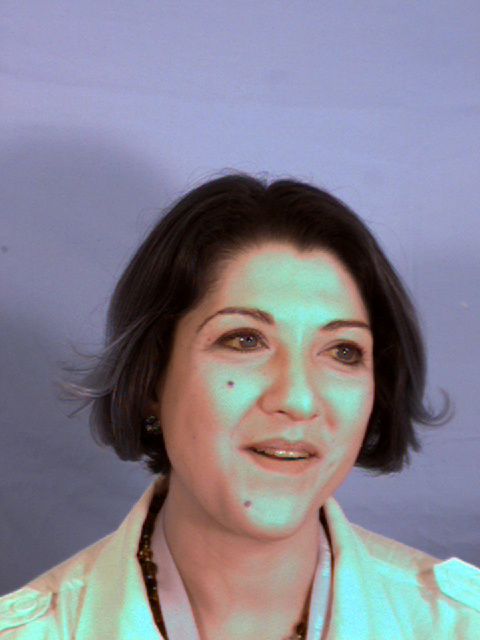

In [29]:
sample = classification_results[classification_results.is_showing_theets==1].sample(1)
load_img('./test/jpg/1/'+sample['file'].values[0])

#### 5.3.2 Not Showing Teeth Sample

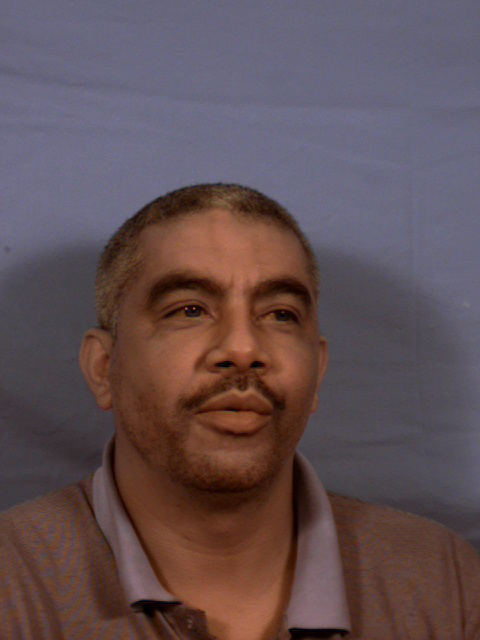

In [30]:
sample = classification_results[classification_results.is_showing_theets==0].sample(1)
load_img('./test/jpg/0/'+sample['file'].values[0])

___
## 6. Results Analysis

Now the entire pipeline has finished is worth to stop and analyse our results.

### 6.1 Train vs Validation Accuracy

Due we use a portion of the original training dataset as a validation dataset, with the goal of avoid a nasty phenomena known as **Overfitting** of the network parameters, that it's the network in some point begin to memorize the training examples that is a bad behavior because the network tryes to classify a completely new image the probability of a bad prediction increases due the network fails in generalize the classification task.

To bring an insight if the strategies applied to use a validation data worked correctly and use transfer learning was worth the additional effort, take a look the above image.

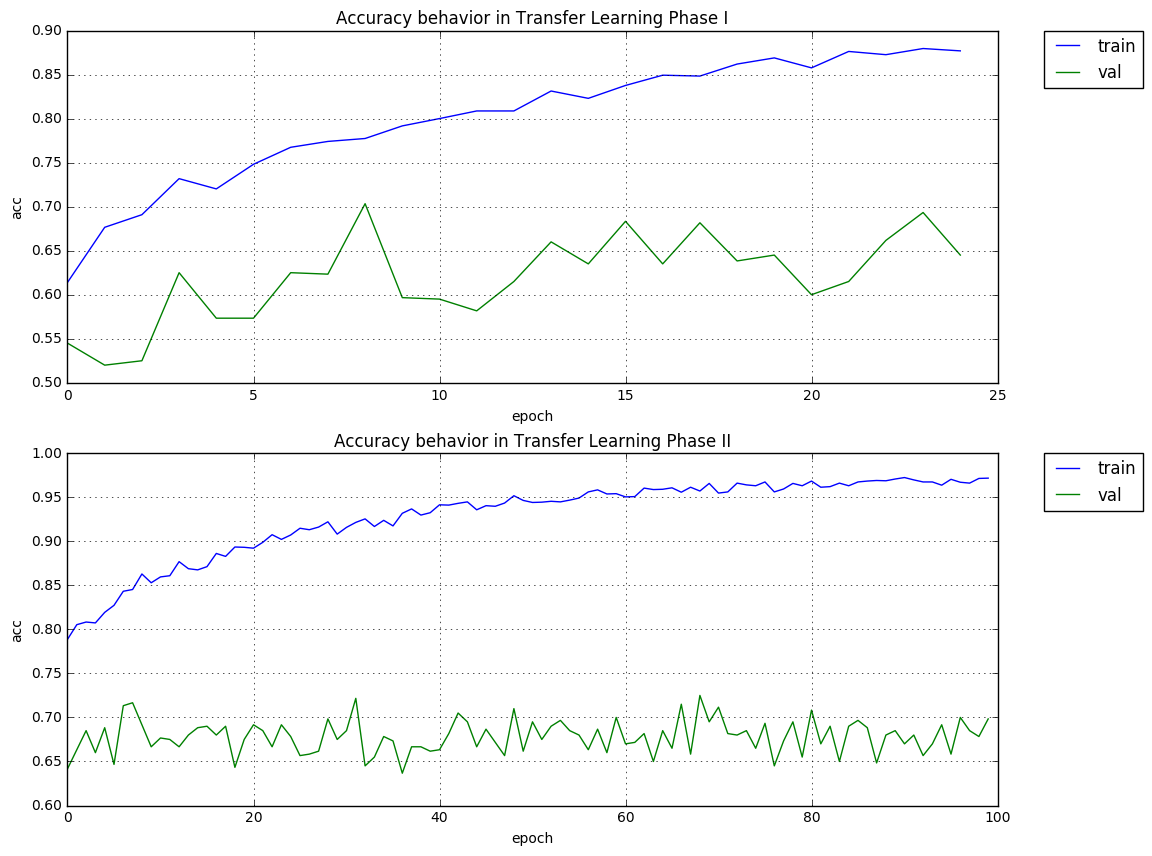

In [51]:
from matplotlib import pyplot as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = (12.0, 10.0)

fig = pl.figure()
plt1 = fig.add_subplot(211)
plt1.plot(list(range(len(history.history['acc']))), history.history['acc'], label="train")
plt1.plot(list(range(len(history.history['val_acc']))), history.history['val_acc'], label="val")
plt1.set_title("Accuracy behavior in Transfer Learning Phase I")
plt1.set_xlabel('epoch')
plt1.set_ylabel('acc')
plt1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt1.grid()

plt2 = fig.add_subplot(212)
plt2.plot(list(range(len(history_fine_tunning.history['acc']))), history_fine_tunning.history['acc'], label="train")
plt2.plot(list(range(len(history_fine_tunning.history['val_acc']))), history_fine_tunning.history['val_acc'], label="val")
plt2.set_title("Accuracy behavior in Transfer Learning Phase II")
plt2.set_xlabel('epoch')
plt2.set_ylabel('acc')
plt2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt2.grid();

As you can see in both phases the **ovefitting** phenomena show up, the accuracy of the training data increase monotonously while the validation accuracy sits around **0.7** that means the network classify nearly with a **100%** of accuracy the training data, but fails with data that never has seen (validation data). So we can conclude the validation data effectively helps to avoid the **overfitting** phenomena saving only the best weights in validation phase.

Also the decision of use transfer learning with the imagenet weights helped to accelerate the convergence of the network due in less than 10 epochs achieves an accuracy of nearly **70%**, that means with transfer learning we can get a network that in few minutes achieves an accuracy close of the best validation accuracy registered for this task.

### 6.2 Confusion Matrix

Using the prediction results along with a hand made ground truth we can see how well (or bad) the network behaves in the task of differentiate between images that contains people showing their teeths and images that doesn't.

In [56]:
#just save the results in csv format
classification_results.to_csv('test_classes.csv')

In [76]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(files['is_showing_theets'].values, 
                            classification_results['is_showing_theets'].values)
c_matrix = pd.DataFrame(c_matrix, index=['not_showing', 'showing'], columns=['not_showing','showing'])
c_matrix

,not_showing,showing
not_showing,381,25
showing,78,267


The confusion matrix shows the real class that belongs the images in the horizontal axis, and how the network classify the images in the vertial axis, for instance the first row (not_showing class) correctly classified as not_showing 381 images, and missclasify 25, same for the showing class classify wrongly 78 and correctly 267 images.

If the classifier were perfect the positions (0,1) and (1,0) should be exactly 0. Below you can see the results represented in percentages.

In [83]:
total_not_showing = c_matrix.iloc[0].sum()
total_showing = c_matrix.iloc[1].sum()
c_matrix.iloc[0] = c_matrix.iloc[0]/total_not_showing*100
c_matrix.iloc[1] = c_matrix.iloc[1]/total_showing*100
pd.options.display.float_format = '{:.2f}%'.format
c_matrix

,not_showing,showing
not_showing,93.84%,6.16%
showing,22.61%,77.39%


As we can see the not_showing category behaves well, meanwhile the showing category doesn't. That behavior need to be evaluated closely to improve the results.

## 7. Conclusions

* The goal of classify the images into showing and not showing teeths was succesfully addressed with an acceptable metrics for a one shot attept.
* The overfitting phenomena was avoided succesfully.
* Transfer learning helps a lot in the speed of the training of the neural net.
* There is room for improvement, probably for this task color in the images could be a characteristics that doesn't helps much rather could be harmful in the classification, transforming the images to greyscale allow us to use deeper nets, or use in a better way the limited resources in the GPU (Only 2GB in mine).

